In [6]:
%load_ext autoreload
%autoreload 2
from fastai import *
from fastai.text import * 

PATH = Path('./data/')
INPUT_DATA = PATH/'perf_db.csv'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading data and choosing hyper parameters

In [9]:
df = pd.read_csv(INPUT_DATA, index_col=0)
df = pd.DataFrame(df.text.unique())
len(df)

In [12]:
data_lm = (TextList.from_df(df, PATH, processor=[TokenizeProcessor(), NumericalizeProcessor(max_vocab=60000, min_freq=1)])
            .random_split_by_pct(0.2)
            .label_for_lm()           
            .databunch(bs=64))


In [13]:
data_lm.save('data-lm-eval-zen')

The next function is used to quickly test fine tuning of some hyper parameters.

In [15]:
def test_hyper_param(lm_str, bs, lrf, epf, lru, epu, drop):
    lm = TextLMDataBunch.load(PATH, lm_str, bs=bs)
    learn = language_model_learner(lm, pretrained_model=URLs.WT103_1, drop_mult=drop)

    learn.fit_one_cycle(epf, lrf)
    learn.unfreeze()
    learn.fit_one_cycle(epu, lru,moms=(0.8,0.7))

    learn.recorder.plot_losses()
    
    return learn

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


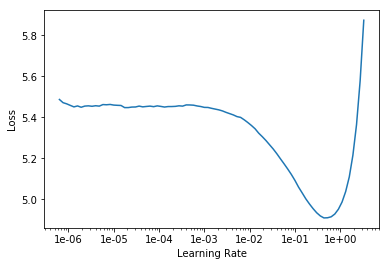

In [16]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.5)
learn.lr_find()
learn.recorder.plot()

The parameter I have choosen are the results of tests I have done and are very depend on the dataset. On another dataset, good hyper parameters could be very different.

epoch,train_loss,valid_loss,accuracy
1,5.273194,4.524457,0.265126
2,4.873284,4.091826,0.282961
3,4.594750,4.005418,0.284060


epoch,train_loss,valid_loss,accuracy
1,4.123355,3.804598,0.287765
2,4.007611,3.645185,0.321101
3,3.915649,3.576758,0.330640
4,3.824987,3.511759,0.335733
5,3.738140,3.469602,0.340410
6,3.644721,3.444941,0.343569
7,3.566956,3.433072,0.344962
8,3.473696,3.412730,0.346273
9,3.381238,3.408101,0.349310
10,3.294344,3.406542,0.348407


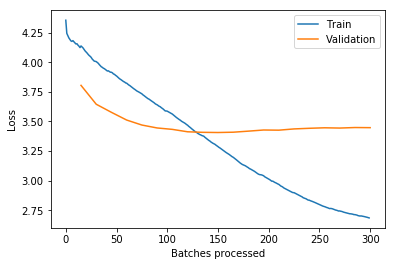

In [36]:
t = test_hyper_param('data-lm-eval-zen', 64, 1e-2, 3, 1e-3, 20, 0.6)

# Training the model

Because the task is text generation, once we have selected the hyperpameters, there is no need of validation set. It is better to use all the data for the final training

In [43]:
data_lm = (TextList.from_df(df, PATH, processor=[TokenizeProcessor(), NumericalizeProcessor(max_vocab=60000, min_freq=1)])
            .random_split_by_pct(0.01)
            .label_for_lm()           
            .databunch(bs=64))

In [44]:
data_lm.save('data-lm-train-zen')

Note that accuracy and valid_loss are meaningless because we have a validation set which is too small (1%)

epoch,train_loss,valid_loss,accuracy
1,5.269088,5.025199,0.190341
2,4.793622,4.391912,0.218750
3,4.473637,4.295146,0.218750


epoch,train_loss,valid_loss,accuracy
1,4.002242,4.133675,0.242898
2,3.893540,4.025743,0.247159
3,3.815819,3.909427,0.265625
4,3.736700,3.936158,0.275568
5,3.652338,3.881320,0.271307
6,3.564542,3.851117,0.262784
7,3.482398,3.889467,0.251420
8,3.392655,3.857884,0.271307
9,3.301254,3.927489,0.267045
10,3.197652,3.971091,0.242898


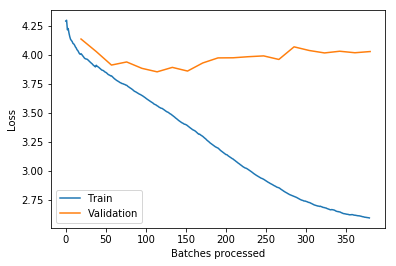

In [45]:
t = test_hyper_param('data-lm-train-zen', 64, 1e-2, 3, 1e-3, 20, 0.6)

In [46]:
t.save('model-deepguru-dataset1')

In [48]:
t.export(fname='full-model-deepguru-dataset1')